In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import os
import seaborn as sns
import itertools

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

from tqdm import tqdm
import warnings
#ignore the warnings about not having different language fonts available 
warnings.filterwarnings(action='ignore') 

### Data Exploration and Processing

In [4]:
orig_train = pd.read_csv('/Users/christinejiang/Documents/Python/data/train_1.csv')
key = pd.read_csv('/Users/christinejiang/Documents/Python/data/key_1.csv')
submission = pd.read_csv('/Users/christinejiang/Documents/Python/data/sample_submission_1.csv')

In [5]:
train = orig_train.fillna(0)

In [6]:
for col in train.columns[1:]:
    train[col] = pd.to_numeric(train[col], downcast = 'integer')

In [7]:
def find_lang(page):
    match = re.search('[a-z][a-z].wikipedia.org', page)
    if match:
        return match.group(0)[0:2]
    return 'na'

def find_article(page):
    match = re.search('[a-z][a-z].wikipedia.org.', page)
    if match:
        article_end = match.start()-1
        return(page[0:article_end])
    return 'na'

def find_access(page):
    match = re.search('.*.wikipedia.org.', page)
    if match:
        access_start = match.end()
        return(page[access_start:])
    return 'na'

train['Language'] = train['Page'].map(find_lang)
train['Article'] = train['Page'].map(find_article)
train['Access'] = train['Page'].map(find_access)

In [8]:
dates = train.iloc[:,1:551]
labels = train[['Article','Language','Access','Page']]
newtrain = pd.concat([labels, dates], axis = 1)

In [9]:
display(newtrain.head(2))
newtrain['Language'].value_counts().sort_values(ascending=False)

,Article,Language,Access,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1,zh,all-access_spider,2NE1_zh.wikipedia.org_all-access_spider,18,11,5,13,14,9,...,32,63,15,26,14,20,22,19,18,20
1,2PM,zh,all-access_spider,2PM_zh.wikipedia.org_all-access_spider,11,14,15,18,11,13,...,17,42,28,15,9,30,52,45,26,20


en    24108
ja    20431
de    18547
na    17855
fr    17802
zh    17229
ru    15022
es    14069
Name: Language, dtype: int64

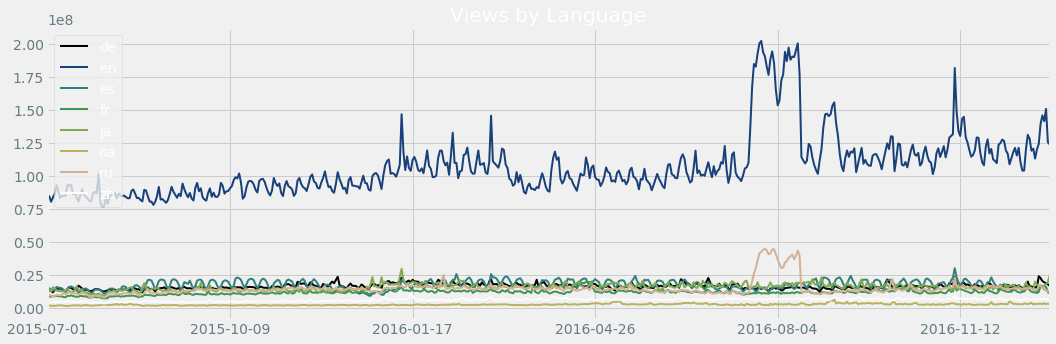

In [206]:
def plot_groups(df, group):
    plt.style.use('fivethirtyeight')
    group = df.groupby(group).sum().reset_index()
    transpose = group.T
    transpose = transpose.rename(columns = transpose.iloc[0]).drop(transpose.index[0])
    figure = transpose.plot(figsize=(16,5), use_index = True, colormap = "gist_earth", lw=2)
    title=plt.title('Views by Language')
    plt.legend(loc='upper left')
    return transpose

transposed = plot_groups(newtrain, 'Language')

In [11]:
languages = newtrain['Language'].unique()
indices = np.random.randint(1,1400,size=3)
num_results = len(indices)
print(indices)

[1398   58  120]


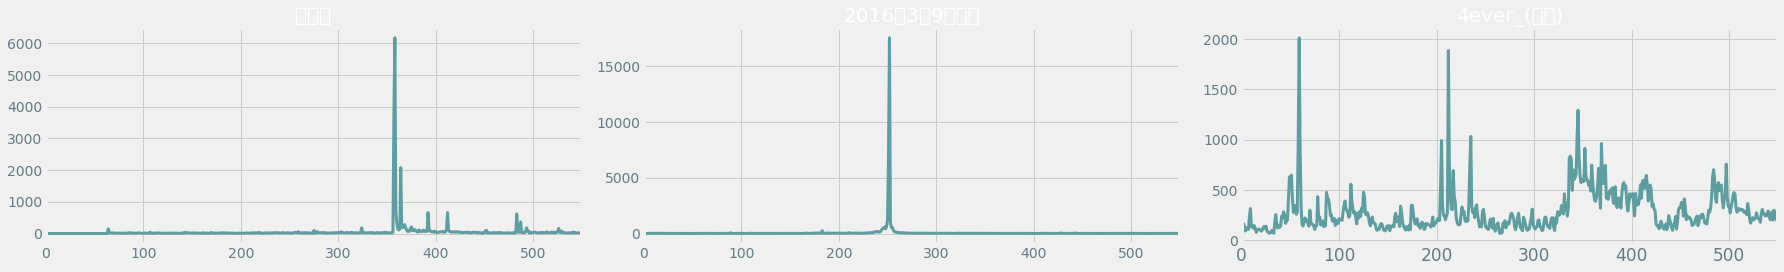

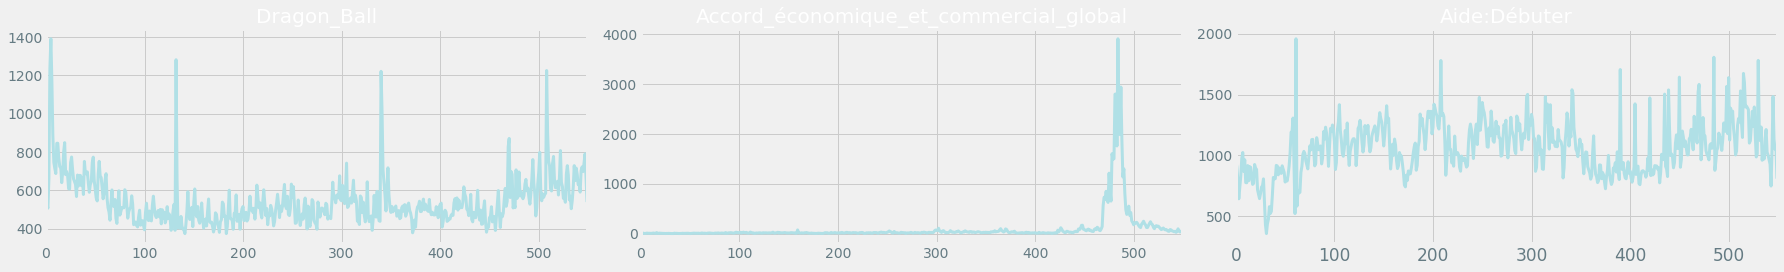

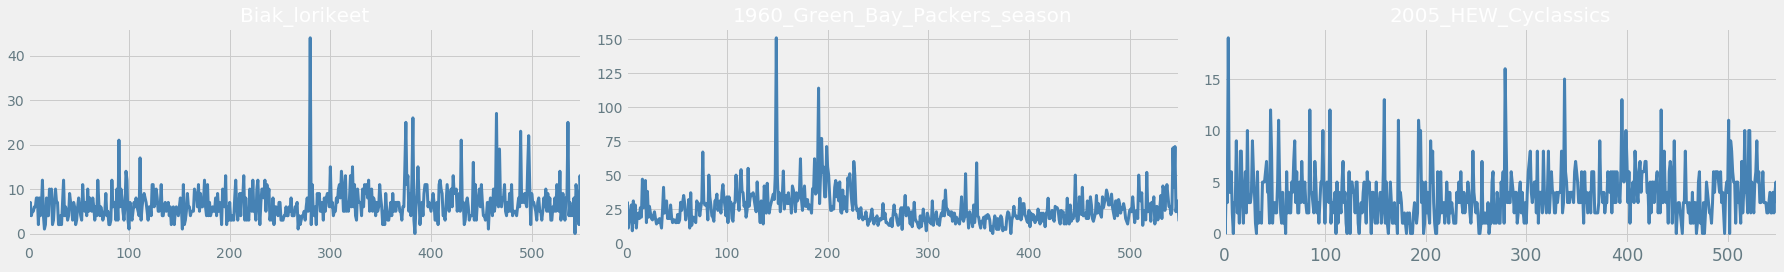

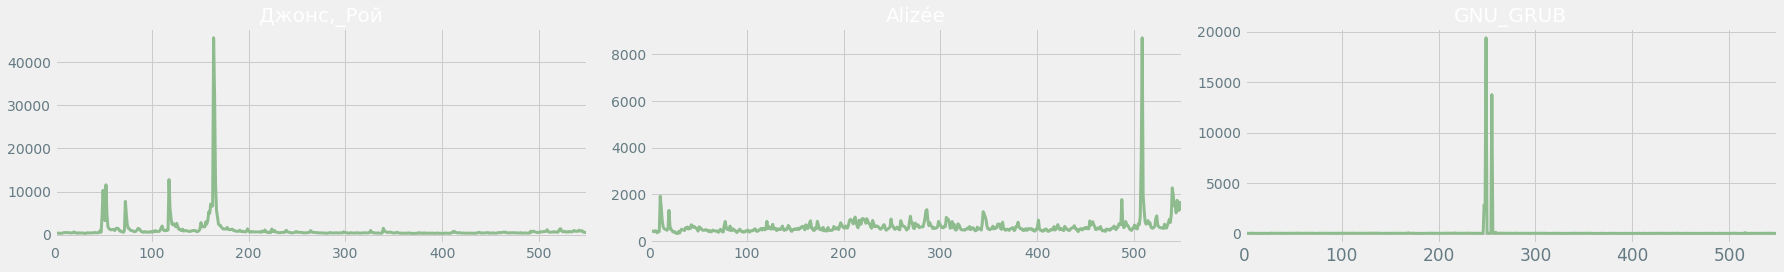

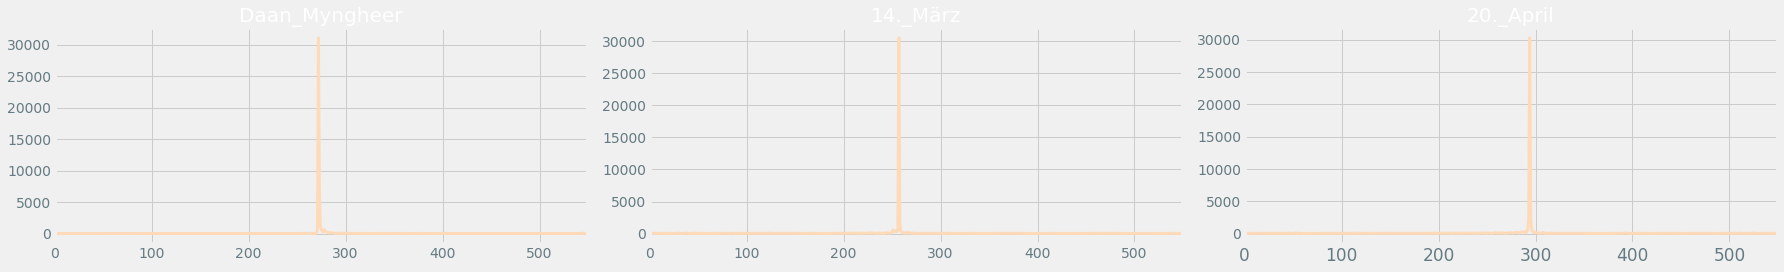

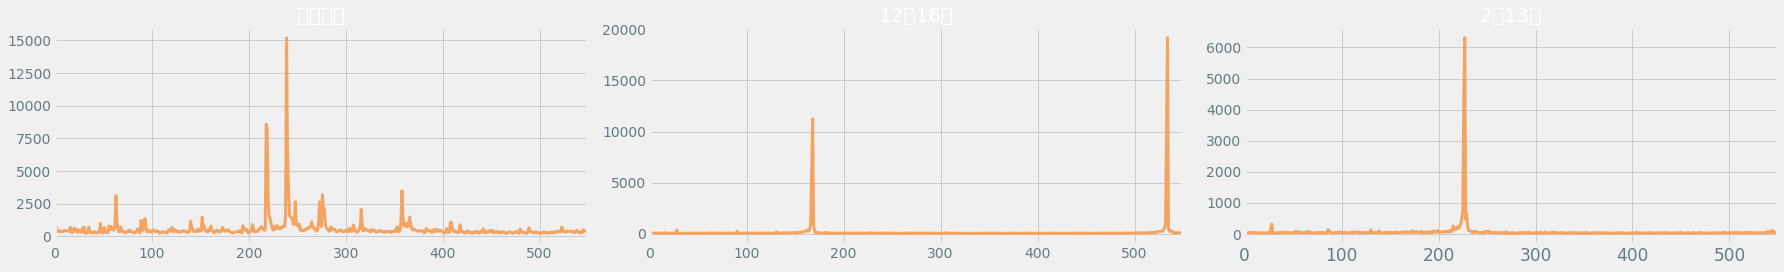

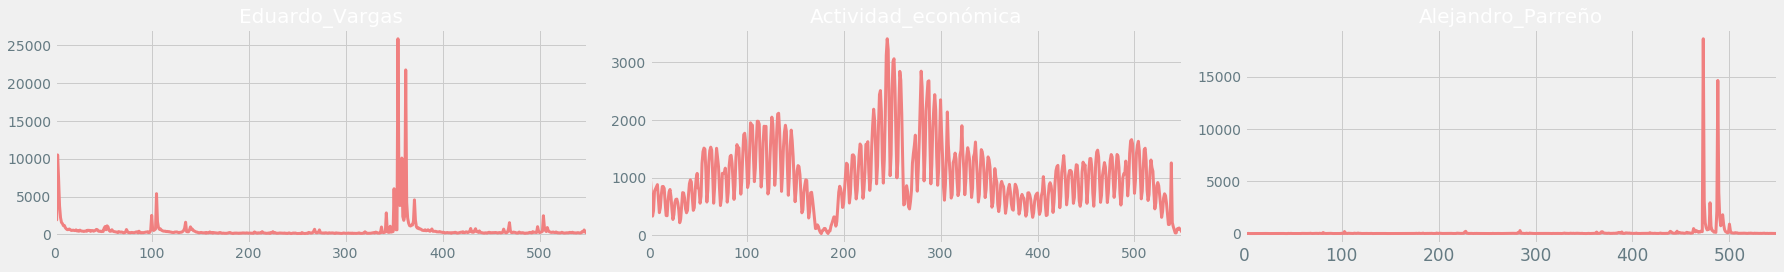

In [198]:
colors = ['cadetblue','powderblue','steelblue','yellowgreen','darkseagreen','peachpuff','sandybrown','lightcoral']
dataframedict = {}
for i,language in enumerate(languages):
    dataframedict[language] = newtrain[newtrain['Language']==language]
    if language != 'na':
        langcolor = colors[i]
        fig, subaxes = plt.subplots(1,num_results,figsize=[25,4])
        pivottable = dataframedict[language].pivot_table(columns='Article')
        for i, index in enumerate(indices):
            singlerecord = pivottable.iloc[:,index]
            plt.xticks(fontsize=17)
            sns.tsplot(singlerecord,ax = subaxes[i],color=langcolor, linewidth=3)
            subaxes[i].set_title(singlerecord.name)
            subaxes[i].title.set_size(20)
            #fig.suptitle(language)
            plt.tight_layout()


### Time Series Modeling

In [213]:
class TimeSeries:
    def __init__(self, dataframedict, language='zh', metric='average'):
        self.metric = metric
        self.language = language
        self.df = dataframedict[language]
        self.time_series = self.aggregate()
        self.adf_statistic = self.stationarity_check()[0]
        self.pvalue = self.stationarity_check()[1]
        self.stationary = self.stationarity_check()[2]
        self.train, self.test = self.train_test_split()
        self.aics = self.arima_model()

    def stationarity_check(self, print_desc=True):
        time_series = self.time_series
        stationarity = adfuller(time_series.iloc[:,0])
        adf_statistic = stationarity[0]
        pvalue = stationarity[1]
        if stationarity[0] < stationarity[4]['5%']:
            stationary = True
        else:
            stationary = False
        return adf_statistic, pvalue, stationary
        
    def aggregate(self):
        metric = self.metric
        language = self.language
        if metric == 'average':
            average = dataframedict[language].iloc[:,4:].mean()
            avg_df = pd.DataFrame(average).rename(columns={0:'Hits'}).set_index(pd.DatetimeIndex(average.index))
            return avg_df
        if metric == 'total':
            total = dataframedict[language].iloc[:,4:].sum()
            total_df = pd.DataFrame(total).rename(columns={0:'Hits'}).set_index(pd.DatetimeIndex(total.index))
            return total_df
        else:
            print ('No such metric available. Choose from [average, total].')
            
    def plot_rolling(self, n=12):
        time_series = self.time_series
        fig, axes = plt.subplots(1,figsize=(15,4))
        time_series.rolling(n).std().plot(color='darkseagreen', ax=axes, lw=2)
        time_series.plot(ax=axes, color='powderblue', lw=2)
        time_series.rolling(n).mean().plot(ax=axes, lw=2)
        plt.title('Time Series with Rolling Statistics')
        legend = axes.legend(['Rolling Std.','Original','Rolling Avg.'])
        
    def plot_acf(self, diffs=1):
        time_series = self.time_series
        df_lag = time_series.diff(periods=diffs)
        plot_acf(df_lag[diffs:], title = 'ACF Lag_' + str(diffs))
        
    def plot_pacf(self, diffs=1):
        time_series = self.time_series
        df_lag = time_series.diff(periods=diffs)
        plot_acf(df_lag[diffs:], title = 'PACF Lag_' + str(diffs))
        
    def train_test_split(self, test_split=0.75):
        time_series = self.time_series
        marker = int(time_series.shape[0]*test_split)
        train = time_series.iloc[0:marker]
        test = time_series.iloc[marker:]
        return train, test
    
    def arima_model(self, pdq_max=2):
        p=q=d=range(0,pdq_max)
        pdq = list(itertools.product(p,d,q))
        aics = []
        best_aic = 9999
        for param in pdq:
            try:
                arima = ARIMA(train, order = param).fit()
                if arima.aic < best_aic:
                    aics = ({param: arima.aic})
                    best_aic = arima.aic
                if arima.aic == best_aic:
                    aics.append({param: arima.aic})
                    best_aic = arima.aic
            except:
                continue
        return aics
    
    def plot_arima(self, order =(1,1,1)):
        time_series = self.time_series
        train = self.train
        test = self.test
        best_arima = ARIMA(train, order = order).fit()
        predictions = best_arima.predict(start=marker, end=time_series.shape[0], typ='levels')
        squared_error = mean_squared_error(test, predictions[:-1])
        mean_error = np.sqrt(squared_error)
        
        figure = avg_df.plot()
        predictions.plot()
        return predictions, mean_error

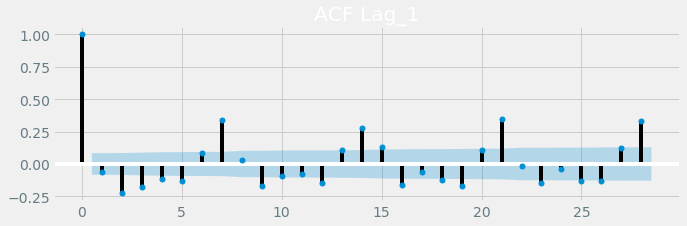

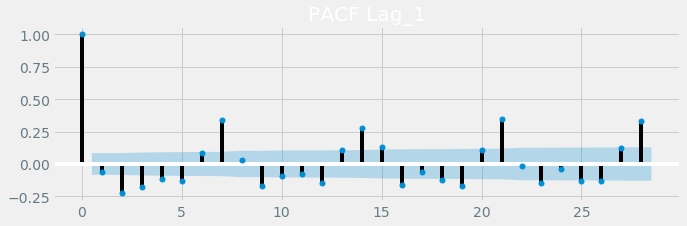

In [214]:
ts = TimeSeries(dataframedict, metric = 'average')
ts.plot_acf()
ts.plot_pacf()

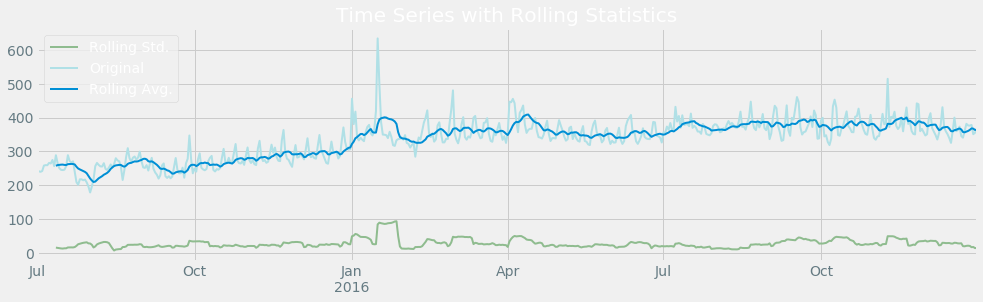

In [215]:
ts.plot_rolling()